# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Определим рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

#### Оглавление:
* [1. Загрузка файла с данными и изучение общей информации.](#step_1)
* [2. Предобработка данных](#step_2)
 * [2.1. Пропуски в высоте потолков](#step_2.1)
 * [2.2. Пропуски в жилой площади и площади кухни](#step_2.2)
 * [2.3. Пропуски в количестве этажей](#step_2.3)
 * [2.4. Пропуски в признаке апартаментов](#step_2.4)
 * [2.5. Пропуски в количестве балконов](#step_2.5)
 * [2.6. Пропуски в данных о наличии парков и прудов](#step_2.6)
 * [2.7. Пропуски в данных о расстоянии до центра и аэропорта](#step_2.7)
 * [2.8. Пропуски в данных сколько дней было размещено объявление](#step_2.8)
 * [2.9. Преобразование типов](#step_2.9)
* [3. Добавление новых столбцов с расчетными данными](#step_3)
 * [ 3.1. Добавление цены квадратного метра](#step_3.1)
 * [ 3.2. Добавление дня недели, месяца и года публикации объявления](#step_3.2)
 * [ 3.3. Добавление категории этажа](#step_3.3)
 * [ 3.4. Добавление соотношения жилой и общей площади, а также отношение площади кухни к общей](#step_3.4)
* [4. Исследовательский анализ данных](#step_4)
 * [ 4.1. Изучение параметров: площадь, цена, число комнат, высота потолков](#step_4.1)
 * [ 4.2. Изучение времени продажи квартир](#step_4.2)
 * [ 4.3. Избавление от выбросов](#step_4.3)
 * [ 4.4. Факторы влияющие на стоимость квартир](#step_4.4)
 * [ 4.5. Выделение центра города](#step_4.5)
 * [ 4.6. Анализ центрального сегмента квартир](#step_4.6)
* [5. Общий вывод](#step_5)

In [1]:
import pandas as pd # Импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set() # Стилизуем графики
plt.style.use('fivethirtyeight')
import warnings # отключим предупреждения анаконды
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(9,6) #Зададим размер графиков по умолчанию

pd.options.display.float_format = '{:.2f}'.format # Зададим удобный формат отображения вещественных чисел

### 1. Загрузка файла с данным и изучение общей информации. 
<a class="anchor" id="step_1"></a>

Загрузим файл с данными

In [2]:
data = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/real_estate_data.csv', sep='\t') # в аргументы добавим разделитель отличный от запятой - обратный слэш
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Для определения местоположения пропусков в наборе данных построим тепловую карту с помощью библиотеки ``seaborn`` где желтым цветом отмечены пропуски а синим заполненные данные

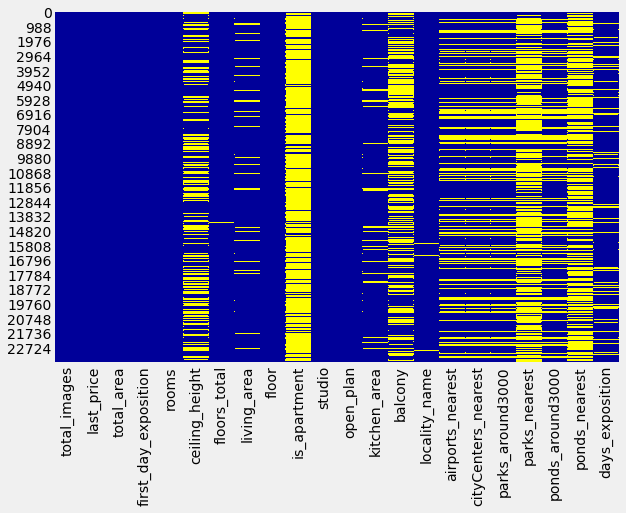

In [4]:
# определяем цвета (желтый - пропущенные данные, синий - не пропущенные)
colours = ['#000099', '#ffff00'] 
sns.heatmap(data[data.columns].isnull(), cmap=sns.color_palette(colours), cbar=False)
plt.show()

### Вывод

Первичный осмотр данных показал что набор состоит из 23699 строк и 22 столбцов. Все числовые значения представлены вещественными числами, а признак того что недвижимость это апартамент и признак даты - строками. В некоторых данных, которые предоставили пользователи наблюдаются пропуски, так же пропуски присутствуют и в данных картографического сервиса. На следующем этапе работы детально изучим эти небрежности и приведем данные в более адекватный вид.

### 2. Предобработка данных
<a class="anchor" id="step_2"></a>

**2.1.** Сперва преобразуем данные предоставленные пользователями и начнем с пропусков в высоте потолков. Выведем описательные статистики по этому столбцу.
<a class="anchor" id="step_2.1"></a>

In [5]:
data['ceiling_height'].describe()

count   14504.00
mean        2.77
std         1.26
min         1.00
25%         2.52
50%         2.65
75%         2.80
max       100.00
Name: ceiling_height, dtype: float64

Как видно в заполненых 14504 из 23699 строках минимальное значение 1 метр, есть так же и 20 метров и 100! Поскольку в описании указано что эти данные получены от пользователя, квалифицируем пропуски и значения не входящие в диапазон от 2 до 5 метров как ошибки и заменим все аномальные значения. Величину для замены выберем медиану, так как она максимально отвечает действительности.

In [6]:
ceiling_height_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median)
data.loc[(data['ceiling_height'] < 2) | (data['ceiling_height'] > 5), 'ceiling_height'] = ceiling_height_median
data['ceiling_height'].describe()

count   23699.00
mean        2.70
std         0.22
min         2.00
25%         2.60
50%         2.65
75%         2.70
max         5.00
Name: ceiling_height, dtype: float64

Согласно описательным статистикам после преобразования данные о приобрели адекватный вид, а малая величина стандартного отклонения говорит малом разбросе вокруг  среднего значения

**2.2.** Обратим внимание на значения площадей квартир: кухни, жилой и общей. Сформируем сводную таблицу. Медиану и количество этих показателей сгруппируем по количеству комнат.
<a class="anchor" id="step_2.2"></a>

In [7]:
data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area'], aggfunc=['median', 'count'])

median                               count                       
      kitchen_area living_area total_area kitchen_area living_area total_area
rooms                                                                        
0              NaN       18.00      26.05            0         183        197
1             9.04       17.60      36.56         7213        7388       8047
2             8.80       30.50      53.00         7286        7296       7940
3             9.50       45.00      73.00         5380        5366       5814
4            11.10       63.60      99.30         1081        1089       1180
5            15.10       91.78     146.45          285         292        326
6            19.50      123.90     184.30           97          99        105
7            20.00      145.00     214.00           52          53         59
8            25.00      161.00     235.70            9          12         12
9            14.30      179.20     300.95            7           7          8
10           19.80      161.40     272.60            3           3          3
11           12.60      133.90     188.90            2           2          2
12          112.00      409.70     900.00            1           1          1
14           21.25      195.15     304.20            2           2          2
15          100.00      409.00     590.00            1           1          1
16           13.00      180.00     270.00            1           1          1
19           27.60      264.50     374.60            1           1          1

Есть квартиры с нулем комнат, таких 197. В объемах нашего набора данных несущественное количество, удалим их. Оставшиеся пустые значения размеров кухонь заменим медианными значениями соотвествующих n-комнатных квартир

In [8]:
# Удалим строки с нулем комнат
data = data.drop(data.query('rooms == 0').index)

In [9]:
# С помощью комбинации методов ``groupby`` и ``transfom`` заполним
# отсутствующие размеры кухонь медианными значениями соответствующих квартир
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] = data.groupby('rooms')['kitchen_area'].transform('median')
data.loc[data['living_area'].isnull(), 'living_area'] = data.groupby('rooms')['living_area'].transform('median')
data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area'], aggfunc=['median', 'count'])

median                               count                       
      kitchen_area living_area total_area kitchen_area living_area total_area
rooms                                                                        
1             9.04       17.60      36.56         8047        8047       8047
2             8.80       30.50      53.00         7940        7940       7940
3             9.50       45.00      73.00         5814        5814       5814
4            11.10       63.60      99.30         1180        1180       1180
5            15.10       91.78     146.45          326         326        326
6            19.50      123.90     184.30          105         105        105
7            20.00      145.00     214.00           59          59         59
8            25.00      161.00     235.70           12          12         12
9            14.30      179.20     300.95            8           8          8
10           19.80      161.40     272.60            3           3          3
11           12.60      133.90     188.90            2           2          2
12          112.00      409.70     900.00            1           1          1
14           21.25      195.15     304.20            2           2          2
15          100.00      409.00     590.00            1           1          1
16           13.00      180.00     270.00            1           1          1
19           27.60      264.50     374.60            1           1          1

Данные о площади кухнонь приблизились к адекватным. В принципе видно два выброса в квартирах с 12 и 15 комнатами, но это единичные случаи и это Санкт-Петербург, там и не такое бывет. Этими выбросами займемся на следующих этапах исследования.

**2.3.** В данных об общем количестве этажей обнаружено 86 пропусков. В объемах нашего набора данных несущественное количество, удалим их.
<a class="anchor" id="step_2.3"></a>

In [10]:
data.dropna(subset=['floors_total'], inplace=True)

**2.4.** В определении апартаментов возможно одно из двух значений ``True`` или ``False`` и из существующих значений 50 это ``True``. Вполне допустимо, что пользователь попросту не указал что недвижимость по умолчанию квартира. Заполним пропуски на ``False``. Так как в сыром наборе данных этот столбец был типа ``Object`` сперва заменим пропуски на ноль, и сразу же преобразуем эти данные к типу ``bool``
<a class="anchor" id="step_2.4"></a>

In [11]:
data['is_apartment'] = data['is_apartment'].fillna(0).astype('bool')
data['is_apartment'].value_counts()

False    23369
True        50
Name: is_apartment, dtype: int64

**2.5.** В данных о количестве балконов так же введем допущение что пользователь просто не указал наличие балконов всвязи с их отсутствием, следовательно пропуски это ноль.
<a class="anchor" id="step_2.5"></a>

In [12]:
data['balcony'] = data['balcony'].fillna(0)

**2.6.** Пропуски в данных картографического сервиса о наличии парков и прудов в радиусе 3000м. заменим по следующему принципу: раз в данных о наличии есть пропуск, значит нет ни пруда ни парка в радиусе 3000м, заменяем пропуски на ноль.
<a class="anchor" id="step_2.6"></a>

In [13]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

**2.7.** Пропуски в названии населенного пункта по прочим косвенным признакам не восстановить и таких пропусков всего 48. Удалим их
<a class="anchor" id="step_2.7"></a>

In [14]:
data.isna().sum()['locality_name']

48

In [15]:
data.dropna(subset=['locality_name'], inplace=True)

Проверим по каким населенным пунктам полностью отсутствует информация о расстоянии до центра и аэропорта.

In [16]:
data.query('airports_nearest != airports_nearest')\
.pivot_table(index='locality_name', values=['cityCenters_nearest', 'airports_nearest'], aggfunc=['count']).count()

count  airports_nearest       343
       cityCenters_nearest    343
dtype: int64

По 343 населенным пунктам информациb о расстоянии до центра и аэропорта нет. В этих населенных пунктах сосоредоточено 23% наших наблюдений. Удалять ценные данные нельзя, а без наличия геокоординат населенных пунктов воостановить не возможно. Просто оставим их без изменения и учтем этот факт на следующих этапах исследования

**2.8.** Пропуски в данных сколько дней было размещено объявление (от публикации до снятия) стоит оставить без изменения, так они могут говорить о том что квартира на текущий момент не продана либо на момент выгрузки данные еще не подгрузились.
<a class="anchor" id="step_2.8"></a>

**2.9.** Как было определено на первом этапе исследования, все чиcловые значения представлены вещественными числами, а некоторые логические типы - строками приведем все типы в порядок. Заменим тип ``float64`` на ``uint8`` где это необходими. Последний тип применяется когда нужно записать целое положительное число от 0 до 255. Данные этого типа занимают мало места а количество комнат, этажей, балконов или фотографий не может быть меньше нуля и вряд ли превысит это значение. Признак того что недвижимость это апартамент мы переобразовали ранее, с признаком того что это студия или недвижимость со свободной планировкой поступим таким же образом. Столбец с датой публикации объявления из строкового преобразуем в ``datetime`` он весит больше, но для дальнейшего преобразования эти данные нам понадобятся именно в таком формате.
<a class="anchor" id="step_2.9"></a>

In [17]:
data = data.astype({'total_images': 'uint8',
                    'rooms': 'uint8', 
                    'floors_total': 'uint8', 
                    'floor': 'uint8',
                    'balcony': 'uint8',
                    'studio': 'bool',
                    'open_plan': 'bool'})
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим наличие дубликатов. Их нет.

In [18]:
data.duplicated().sum()

0

Обновим описательные статистики и тепловую катру пропусков. Убедимся в результатах преобразований. Статистики преобрели более адекватный вид, а в пропусках остались лишь те что мы допустили.

In [19]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23371.00,23371.00,23371.00,23371.00,23371.00,23371.00,23371.00,23371.00,23371.00,23371.00,17924.00,17947.00,23371.00,8002.00,23371.00,8968.00,20214.00
mean,9.90,6566584.28,60.58,2.09,2.70,10.62,34.45,5.86,10.46,0.59,28824.93,14197.80,0.47,490.25,0.59,518.24,181.37
std,5.68,10942476.06,35.61,1.07,0.22,6.57,21.76,4.85,5.66,0.96,12629.36,8631.61,0.75,341.66,0.88,278.04,220.09
min,0.00,12190.00,12.00,1.00,2.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3450000.00,40.20,1.00,2.60,5.00,18.50,2.00,7.30,0.00,18584.25,9236.00,0.00,288.00,0.00,293.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.50,4.00,9.04,0.00,26770.00,13092.00,0.00,454.00,0.00,503.00,96.00
75%,14.00,6800000.00,70.00,3.00,2.70,16.00,42.80,8.00,11.50,1.00,37289.50,16285.00,1.00,612.00,1.00,730.00,232.00
max,50.00,763000000.00,900.00,19.00,5.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23371 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23371 non-null  uint8         
 1   last_price            23371 non-null  float64       
 2   total_area            23371 non-null  float64       
 3   first_day_exposition  23371 non-null  datetime64[ns]
 4   rooms                 23371 non-null  uint8         
 5   ceiling_height        23371 non-null  float64       
 6   floors_total          23371 non-null  uint8         
 7   living_area           23371 non-null  float64       
 8   floor                 23371 non-null  uint8         
 9   is_apartment          23371 non-null  bool          
 10  studio                23371 non-null  bool          
 11  open_plan             23371 non-null  bool          
 12  kitchen_area          23371 non-null  float64       
 13  balcony         

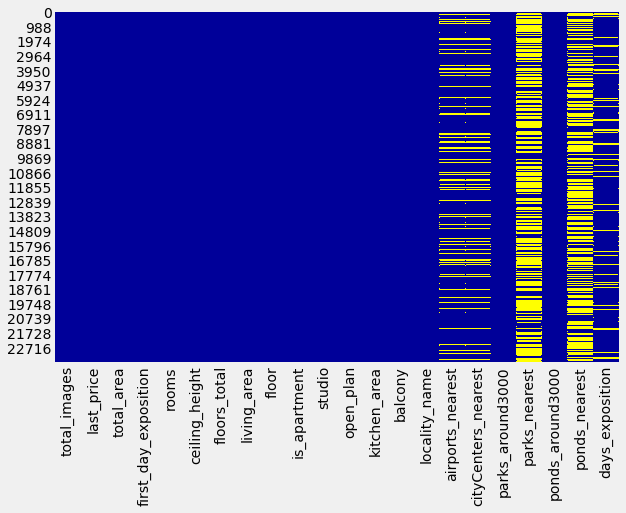

In [21]:
# определяем цвета (желтый - пропущенные данные, синий - не пропущенные)
colours = ['#000099', '#ffff00'] 
sns.heatmap(data[data.columns].isnull(), cmap=sns.color_palette(colours), cbar=False)
plt.show()

### Вывод
На первом этапе исследования мы опрелелили в каких столбцах обнаружены пропуски данных. В некоторых столбцах заменили пропуски согласно логике, в некторых несущественное количетво удалили, в некоторых оставили без измненения. Привели к неверно подгруженные типы данных к правильным. Продолжим исследование.

### Шаг 3. Добавление в таблицу новых столбцов
<a class="anchor" id="step_3"></a>

**3.1.** Добавление цены квадратного метра
<a class="anchor" id="step_3.1"></a>

In [22]:
# Добавим столбец просто поделив цену недвижимости на общую площадь
data['price_per_meter'] = data['last_price'] / data['total_area']
data['price_per_meter'].describe()

count     23371.00
mean      99330.31
std       50526.68
min         111.83
25%       76470.59
50%       94890.51
75%      114054.06
max     1907500.00
Name: price_per_meter, dtype: float64

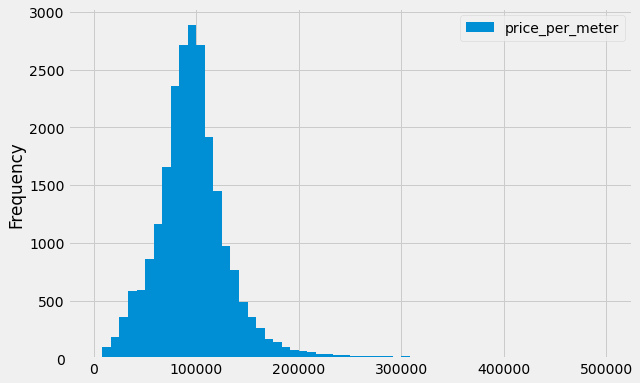

In [23]:
data.plot(y='price_per_meter', kind='hist', bins=60, grid=True, range=(0, 500000))
plt.show()

Распределение среденей цены за метр имеет нормальный вид с небольшим числом значений после 200000р/метр, что в принципе отвечает ожиданиям. Дорогое жилье разнообразно и немногочисленно.

**3.2.** Добавление данных о дне недели, месяце и годе публикации объявления
<a class="anchor" id="step_3.2"></a>

In [24]:
# Применим методы ``dt`` для преобразования даты в день недели, месяц и год
data['weekday_exp'] = data['first_day_exposition'].dt.weekday
data['month_exp'] = data['first_day_exposition'].dt.month
data['year_exp'] = data['first_day_exposition'].dt.year

**3.3.** Добавим в набор столбец определяющий тип этажа
<a class="anchor" id="step_3.3"></a>

In [25]:
# Создадим и применим функцию категоризации этажей согласно описанным условиям
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

**3.4.** Добавим в набор соотношение жилой и общей площади, а также отношение площади кухни к общей.
<a class="anchor" id="step_3.4"></a>

In [26]:
data['living_part'] = data['living_area'] / data['total_area']
data['kitchen_part'] = data['kitchen_area'] / data['total_area']

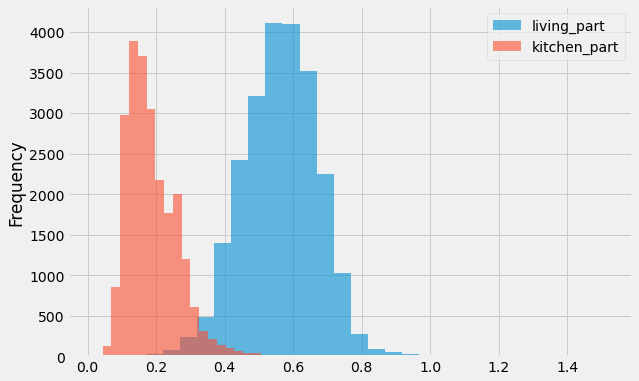

In [27]:
# Зададим первый график как ось, который передадим как аргумент во второй график
# таким образом выведем совмещение двух графиков
ax = data.plot(y='living_part', kind='hist', bins=30, linewidth=5, alpha=0.6, grid=True) 
data.plot(y='kitchen_part', kind='hist', bins=30, linewidth=5, alpha=0.6, grid=True, ax = ax)
plt.show()

Как видно на графиках, соотношение жилой площади к общей в среднем составляет 60% и имеет нормальное распределение. Как известно кухни занимают меньшую часть квартиры, по этому разброс вокруг средней в 20% меньше и график как бы смещен влево.

In [28]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exp,month_exp,year_exp,floor_type,living_part,kitchen_part
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,2.00,755.00,NaN,120370.37,3,3,2019,другой,0.47,0.23
1,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,False,...,0.00,NaN,81.00,82920.79,1,12,2018,первый,0.46,0.27
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,False,...,2.00,574.00,558.00,92785.71,3,8,2015,другой,0.61,0.15
3,0,64900000.00,159.00,2015-07-24,3,2.65,14,45.00,9,False,...,3.00,234.00,424.00,408176.10,4,7,2015,другой,0.28,0.06
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,1.00,48.00,121.00,100000.00,1,6,2018,другой,0.32,0.41


По первым пяти строкам понятно что все добавленные данные ответчает ожиданиям.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:
<a class="anchor" id="step_4"></a>

**4.1** Изучение параметров: площадь, цена, число комнат, высота потолков.
<a class="anchor" id="step_4.1"></a>

In [29]:
# Приготовим срез датафрейма из столбцов, параметры которые хотим оценить
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']

In [30]:
data[columns].describe() # Традиционно выведем статистики

,total_area,last_price,rooms,ceiling_height
count,23371.00,23371.00,23371.00,23371.00
mean,60.58,6566584.28,2.09,2.70
std,35.61,10942476.06,1.07,0.22
min,12.00,12190.00,1.00,2.00
25%,40.20,3450000.00,1.00,2.60
50%,52.00,4650000.00,2.00,2.65
75%,70.00,6800000.00,3.00,2.70
max,900.00,763000000.00,19.00,5.00


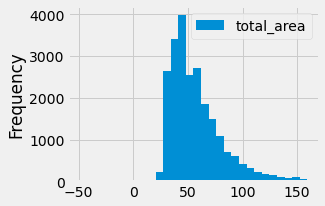

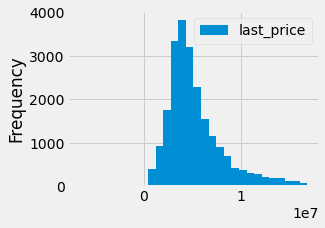

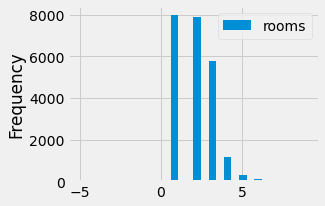

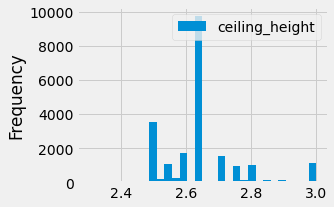

In [31]:
# Для построения гистограмм для выбранных столбцов в цикле зададим ганицы от Q1-3*IQR до Q3+3*IQR
for col in columns:
    q1, q3 = data[col].describe()['25%'], data[col].describe()['75%'] # рассчитаем 1 и 3 квартили
    iqr = q3 - q1 # рассчитаем межквартильный размах
    ranges = ((q1 - 3 * iqr), (q3 + 3 * iqr)) # зададим диапазон графиков
    # для каждого столбца из списка выведем гистограмму
    data[col].plot(y = col, kind='hist', figsize=(4,3), bins=30, range=ranges, grid=True)
    plt.legend()
    plt.show()

На всех графиках сразу же заметны короткая голова и длинный хвост. И это очевидно. Типового жилья с одной-двумя комнатами, площадью около 50м и ценой около 5млн всегда больше. Зато квартиры находящиеся в хвосте представлены большой вариативностью. Там и по 15-17 комнат и потолки по 4-5 метров и площадь до 800м. Экслюзив - одним словом. Как видно цена имеет самое выраженное смещение влево, поэтому единичные дорогие экземпляры заметно отдаляют среднюю от медианы в сторону увеличения.

**4.2** Изучение времени продажи квартиры.
<a class="anchor" id="step_4.2"></a>

Выведем сводную статистику и построим гистограмму для исследуемого параметра

In [32]:
data['days_exposition'].describe()

count   20214.00
mean      181.37
std       220.09
min         1.00
25%        45.00
50%        96.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

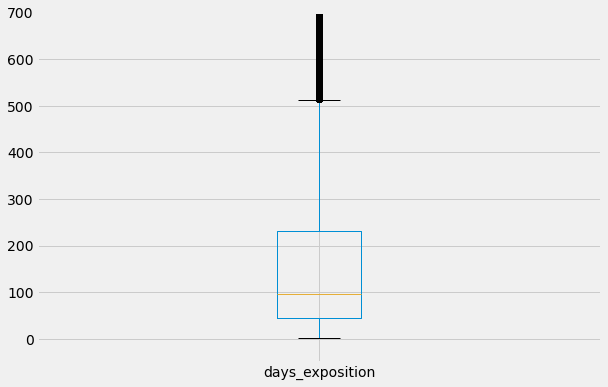

In [33]:
data.plot(y ='days_exposition', figsize=(9,6), kind='box', grid=True)
plt.ylim(-50, 700)
plt.show()

Как сразу видно среднее количество дней продажи в два раза больше медианы, это говорит о большом количестве аномально длинных сроков, что подтвержается "вереницей" выбросов после 400 дней вплоть до почти 5лет. Крайне короткие сроки встречаются очень часто. Скорее всего это ошибочно поданные объявления либо в течении короткого времени было изменение цены. Таким образом объявление закрылось и открылось вновь с новой ценой. За разъяснением этото момента стоит обратиться к инженерам баз данных

**4.3** Избавление от выбросов.
<a class="anchor" id="step_4.3"></a>

Одним из способов избавления от выбросов является отсечение значений до 5-го квантиля и после 95-го. Вспомним, что в наших наблюдениях есть примеры и по 17 комнат и потолки по 5 метров и площадь по 900м и цена по 760млн. Приведем нашу недвижимость к "середнячку". Поскольку наши данные смещены влево слегка расширим границы и отбросим значения  до 3-го квантиля, а не 5-го.

In [34]:
column_list = ['last_price', 'total_area', # Подготовим список интересующих столбцов
       'ceiling_height', 'living_area', 'rooms',
       'kitchen_area', 'airports_nearest', 'cityCenters_nearest',
       'parks_nearest', 
       'ponds_nearest', 
       'days_exposition', 'price_per_meter']
data_clear = data.copy() # Создадим копию набора данных  в которой будем отсекать все выбросы

In [35]:
# Зададим цикл, который будет для каждого столбца определять нижнюю и верхнюю границы
for col in column_list:
    try: # Применим try/except на случай ошибки
        q_low = data[col].quantile(0.03) 
        q_hi = data[col].quantile(0.95)
        # запишем обновленный столбец имеющий поверх прежнего, но т.к. его размерность мешьше
        # но вместо отброшенных выбросов будет NaN
        # столбцы не попавшие в цикл останутся без изменения
        # нижняя граница числа комнат определяется как целочисленная 1, применим мягкое сравнение, чтобы не потерять данные
        data_clear[col] = data.loc[(data[col] >= q_low) & (data[col] <= q_hi)][col]
        # Параллельно выведем на печать определенные в цикле границы
        print(f'{col}: (нижняя граница {q_low:.0f} ------- верхняя граница {q_hi:.0f})')
    except:
        print('not ok')

last_price: (нижняя граница 1550000 ------- верхняя граница 15353500)
total_area: (нижняя граница 30 ------- верхняя граница 116)
ceiling_height: (нижняя граница 2 ------- верхняя граница 3)
living_area: (нижняя граница 15 ------- верхняя граница 68)
rooms: (нижняя граница 1 ------- верхняя граница 4)
kitchen_area: (нижняя граница 5 ------- верхняя граница 20)
airports_nearest: (нижняя граница 10694 ------- верхняя граница 51340)
cityCenters_nearest: (нижняя граница 2600 ------- верхняя граница 31773)
parks_nearest: (нижняя граница 58 ------- верхняя граница 967)
ponds_nearest: (нижняя граница 68 ------- верхняя граница 978)
days_exposition: (нижняя граница 7 ------- верхняя граница 649)
price_per_meter: (нижняя граница 34535 ------- верхняя граница 160819)


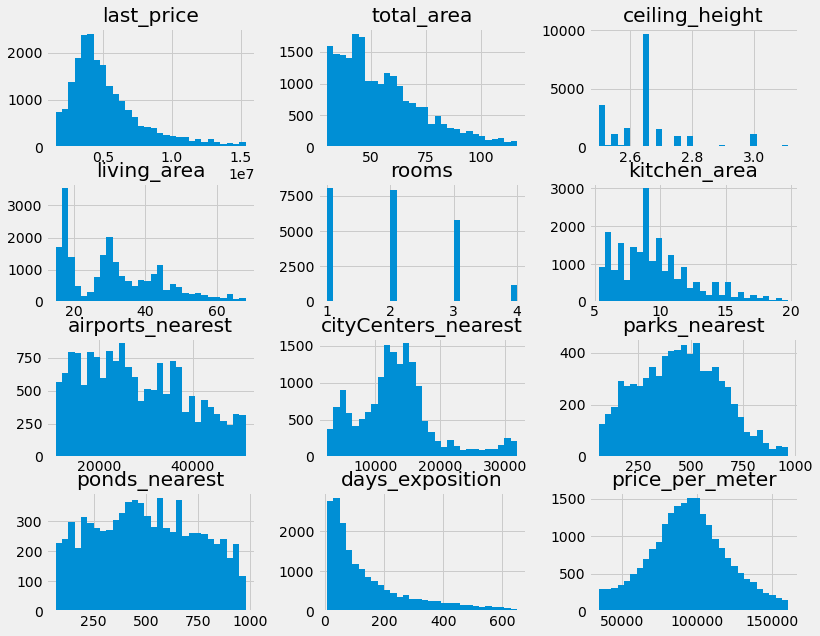

In [36]:
# Для построения гистограмм по столбцам с отсеченными выбросами применим метод hist к срезу датафрейма
# разместим частоты по 30 корзинам
data_clear[column_list].hist(figsize=(12,10), bins=30)
plt.show()

In [37]:
data_clear.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exp,month_exp,year_exp,living_part,kitchen_part
count,23371.00,21515.00,21680.00,22852.00,22136.00,23371.00,21536.00,23371.00,21553.00,23371.00,...,7363.00,23371.00,8253.00,18609.00,21500.00,23371.00,23371.00,23371.00,23371.00,23371.00
mean,9.90,5318432.64,55.42,2.01,2.66,10.62,31.53,5.86,9.64,0.59,...,446.37,0.59,503.06,148.53,94368.44,2.57,6.40,2017.37,0.56,0.19
std,5.68,2676688.85,19.23,0.90,0.13,6.57,12.77,4.85,2.96,0.96,...,197.31,0.88,242.99,144.38,26124.17,1.79,3.49,1.04,0.11,0.07
min,0.00,1550000.00,30.00,1.00,2.50,1.00,15.00,1.00,5.30,0.00,...,59.00,0.00,68.00,7.00,34539.47,0.00,1.00,2014.00,0.02,0.02
25%,6.00,3500000.00,40.50,1.00,2.60,5.00,18.80,2.00,7.50,0.00,...,294.00,0.00,303.00,45.00,77419.35,1.00,3.00,2017.00,0.49,0.13
50%,9.00,4600000.00,51.10,2.00,2.65,9.00,30.00,4.00,9.04,0.00,...,447.00,0.00,494.00,92.00,94230.77,3.00,6.00,2017.00,0.57,0.17
75%,14.00,6416750.00,66.40,3.00,2.70,16.00,41.00,8.00,11.00,1.00,...,591.00,1.00,698.00,206.00,111007.46,4.00,10.00,2018.00,0.64,0.23
max,50.00,15350000.00,116.30,4.00,3.11,60.00,68.00,33.00,19.80,5.00,...,967.00,3.00,977.00,649.00,160769.23,6.00,12.00,2019.00,1.51,0.79


Статистики показывают ожидаемый результат. В новом датафрейме повились пропуски, но пропуски контролируемые и оправданые. Минимальные и максимальные значения не превышают границ отсечения, а средние приблизились к медианам. Это говорит о том что влияние отсеченных выбросов уменьшилось.
- Расстояние до аэропорта распределено относительно равномерно с небольшими скачками. Так скорее сказывается эффект равномерности застройки
- Потолки переставленны преимущественно стандартными 2,65м., но достаточно квартир с высотой 2,5м.
- Большинство квартир расположено между 8 и 17км. от центра. Так же достаточно много в самом цетре (до 5км.).
- Не удивительно что время продаж квартир распределено таким образом, как представлено на гистограмме. Чаще всего продажа присходит в течении первых 2-3 месяцев.
- По площади квартиры в основном 40-метровые с жилой площадью примерно 17м. и кухней около 9м.
- Цены за квартиры после отсечения выбросов представлены диапазоном от 1,5 до 150млн. Вспомни что ранее встречались искажающие статистику экземпляры и по 760млн.
- Комнат в основном 1 или 2, реже 3
- Цена за метр имеет практически идеальное нормальное распределение и расположилось вокруг средней в 94,3тыс.

**4.4** Факторы, влияющие на стоимость квартир.
<a class="anchor" id="step_4.4"></a>

Для ответа на поставленный вопрос проведем корреляционный анализ, суть которого в определении уровня завистимости одной величины от другой. Коэффициент корреляции может принимать значения от -1 до 1. В первом случае величины полностью обратно зависимы, во втором прямо зависимы. В нуле связи между величинами нет.

In [38]:
# Применим к очищенному датафрейму метод corr по столбцу с ценой и отсортируем по убыванию
data_clear.corr()['last_price'].sort_values(ascending=False)

last_price             1.00
total_area             0.72
living_area            0.56
price_per_meter        0.54
kitchen_area           0.49
rooms                  0.46
ceiling_height         0.36
ponds_around3000       0.28
parks_around3000       0.25
total_images           0.15
floors_total           0.11
floor                  0.08
days_exposition        0.08
balcony                0.05
is_apartment           0.03
living_part            0.02
month_exp              0.00
open_plan              0.00
parks_nearest         -0.01
year_exp              -0.01
weekday_exp           -0.01
airports_nearest      -0.01
studio                -0.02
ponds_nearest         -0.05
kitchen_part          -0.18
cityCenters_nearest   -0.37
Name: last_price, dtype: float64

Наиболее сильная связь наблюдается между Стоимостью квартиры и общей площадью. Далее идет жилая площадь и цена за 1 квадратный метр. Метр как следствие деления цены на площадь. В некторой мере оказывают влияние площадь кухни, количество комнат, высота потолков, но они так же зависят от общей площади (не бывает 40метровой трёшки с потолками 2,5). Удаленность от центра оказывает не сильную обратную связь, что собственно, объяснимо.

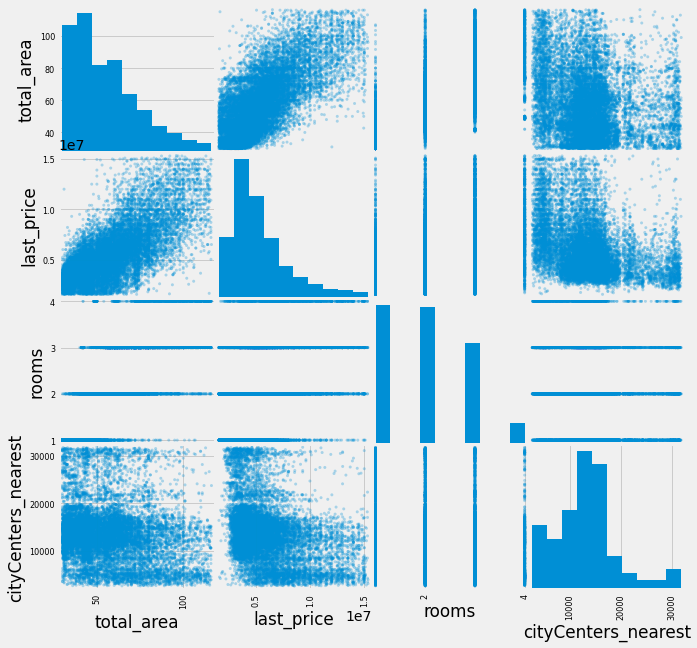

In [39]:
# Для постоения матрицы рассеяния передадим методу scatter_matrix срез чистого датафрейма но нужным столбцам
pd.plotting.scatter_matrix(data_clear[['total_area', 
                       'last_price', 
                       'rooms', 
                       'cityCenters_nearest']], figsize=(10, 10), alpha=0.3)
plt.show()

Матрица рассеивания более подробно раскрывает эффект корреляции. Так очень заметна связь стоимости и общей площади, общей площади и количества комнат, количества комнат и удаленности от центра (чем дальше тем 4комнатных квартир меньше). Так же видна очень слабая но отрцательная связь между удаленностью от центра и стоимостью. Между удаленностью и общей площадью связь еще слабее, однако заметно что чем дальше тем больших квартир меньше.

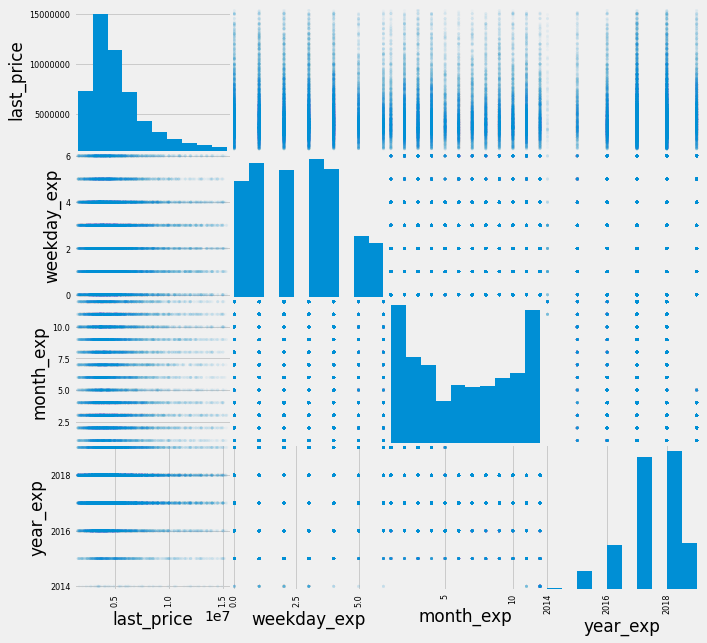

In [40]:
# Аналогичным образом построи матрицу для определения связи между стоимостью и временем продажи
pd.plotting.scatter_matrix(data_clear[['last_price',
                       'weekday_exp',
                       'month_exp',
                       'year_exp']], figsize=(10, 10), alpha=0.03)
plt.show()

Матрица говорит нам о том что в выходные дни меньше размещается объявлений, и стоимость не зависит от конретного дня недели. То же самое относится к месяцам, более активные зимние месяцы, но на цену не влияют. По годам картина интересней. Плотность объялений растет от 2014 и обрывается на 2019, первое объясняется развитем плавным агригатора с выходом на плато в 2017, а второе выгрузкой базы данных в середине 2019. Взаимосвязь между увеличением стоимости квартир и годом объясняется инфляцией.

In [41]:
price_floor = data.pivot_table(index='floor_type', values=['last_price'])
price_floor.sort_values(by='last_price', ascending=False)

,last_price
floor_type,
последний,7372821.48
другой,6705466.33
первый,4816582.15


Для оценки взаимосвязи типа этажа и цены диаграмма рассеяния не применима, т.к. тип этажа категориальная величина. В сводной таблице видно что первый этаж самый непопулярный, а самый востребованный последний. И это очевидно, людям не нравится когда подсматривают в окна, а наблюдать на прохожих сверху - само то.

Для выделения средней стоимости квадратного метра в топ 10 населенных пунктов, разумнее всего воспользоваться сводной таблицей.

In [42]:
# Создадим сводную таблицу по населенному пункту, количеству объялений и средней цене за квадратный метр
top10_locality = data_clear.pivot_table(index='locality_name', values=['price_per_meter'], aggfunc=['count','mean'])
# Скорректируем названия столбцов
top10_locality.columns = ['amount_purpose', 'mean_price']
# Обновим полученный датафрейм остортировав значения по убыванию и оставив первые 10
top10_locality = top10_locality.sort_values(by='amount_purpose', ascending=False).head(10)
# Повторно отсортируем полученные 10 значений и применим условное форматирование столбца mean_price с помощью метода style
top10_locality.sort_values(by='mean_price', ascending=False).style.bar(subset=['mean_price'], color='#67A5EB')

,amount_purpose,mean_price
locality_name,,
Санкт-Петербург,14382,105227.828554
Пушкин,363,101607.984405
деревня Кудрово,283,92297.218847
посёлок Парголово,323,90289.778393
посёлок Мурино,494,85036.645789
посёлок Шушары,435,78277.935520
Колпино,338,75424.579098
Гатчина,303,69430.210553
Всеволожск,390,67247.279551


In [43]:
# Применим цикл для вывода информации о месте с самой высокой и низкой ценой метра
top10_dict = top10_locality['mean_price'].to_dict()
for row in top10_dict.items():
    if row[1] == top10_locality.mean_price.max():
        print(f'в городе {row[0]} самая высокая средняя цена 1 метра - {row[1]:.0f}р.')
for row in top10_dict.items():
    if row[1] == top10_locality.mean_price.min():
        print(f'в городе {row[0]} самая низкая средняя цена 1 метра - {row[1]:.0f}р.')

в городе Санкт-Петербург самая высокая средняя цена 1 метра - 105228р.
в городе Выборг самая низкая средняя цена 1 метра - 59222р.


**4.5** Выделение центра города.
<a class="anchor" id="step_4.5"></a>

Определим центральный район города по заметному изменению средней цены за квадратный метр на столбиковой диаграмме в разбивке по километрам.

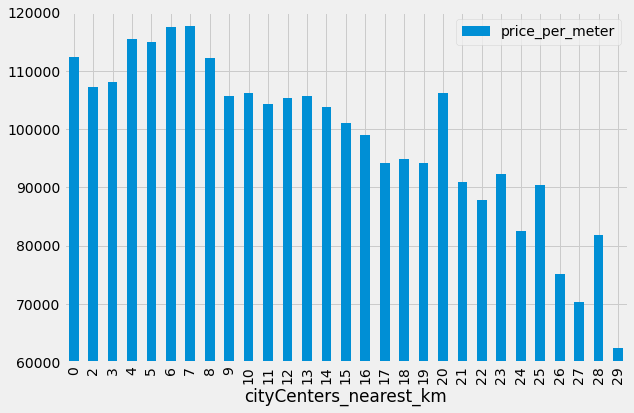

In [44]:
# В чистый датафрейм добавим столбец с километрами приведенными к целому числу
data_clear['cityCenters_nearest_km'] = ((data_clear['cityCenters_nearest'] / 1000).fillna(0).astype('int'))
# На основе среза по локации Санкт-Петербург построим сводную таблицу
spb_purpose_pivot = data_clear.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='price_per_meter')
# Построим столбиковуб диаграмму из полученной сводной таблицы
spb_purpose_pivot.plot(kind='bar', grid=True)
plt.ylim(60000,120000)
plt.show()

Прямо резкого падения цены не наблюдается но все же заметен переход на 9 километре. На 20 километре наблюдается странный всплеск. Учитывая тот факт что на предыдущих этапах мы отсекли значения свыше 160тыс/м и наблюдаемое начение цены на 20 километре около 105тыс/м, что превышает среднюю в 94тыс/м всего на 10% дополнительное отсечение сильно сгладит значения. Скорее всего на этом участке какое-то иное устойчивое явление. Например престижный район.

**4.6** Анализ центрального сигмента квартир.
<a class="anchor" id="step_4.6"></a>

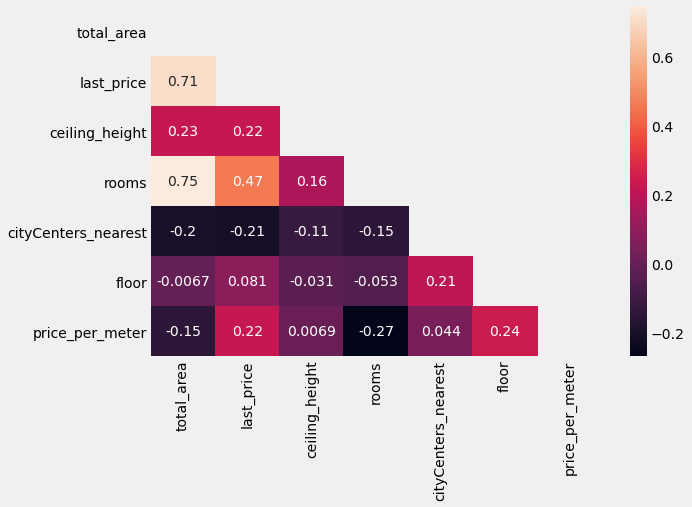

In [45]:
data_spb_inside = data_clear.query('locality_name == "Санкт-Петербург" & cityCenters_nearest_km < 9')[['total_area', 
                       'last_price', 'ceiling_height', 'rooms', 'cityCenters_nearest', 'floor', 'price_per_meter']]
# data_spb_inside.corr()
mask = np.triu(data_spb_inside.corr())
sns.heatmap(data_spb_inside.corr(), annot=True, fmt='.2g', mask=mask, cbar=True)
plt.show()

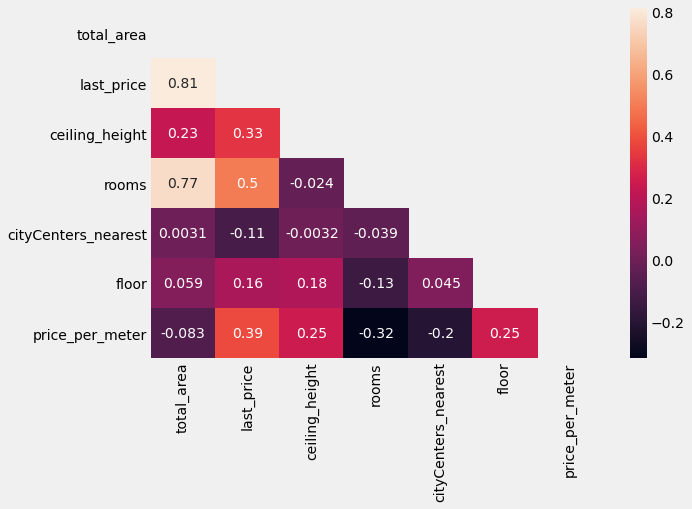

In [46]:
data_spb_inside = data_clear.query('locality_name == "Санкт-Петербург" & cityCenters_nearest_km > 9')[['total_area', 
                       'last_price', 'ceiling_height', 'rooms', 'cityCenters_nearest', 'floor', 'price_per_meter']]
# data_spb_inside.corr()
mask = np.triu(data_spb_inside.corr())
sns.heatmap(data_spb_inside.corr(), annot=True, fmt='.2g', mask=mask, cbar=True)
plt.show()

Тенденция сильной зависимости стоимости квартиры от общей площади сохраняется. При этом заметно уменьшается связь между удаленностью и площадью, удаленностью и стоимостью. Квартиры в большей мере представлены двушками и трёшками, а потолки в основнном 2,65, но в отличии от остальных наблюдений на втором месте по популярности месте 3-метровые потолки. Все положительные корреляции между стоимостью квартир и жилой площадью, высотой потолков, площадью кухни, количеством комнат, сохраняются и обусловлены влиянием третьего фактора - общей площади, связь коротого и стоимости, как мы установили, наиболее сильная.

In [47]:
# Расчитаем коэффициенты корреляции для ценрта города
center_inside = (
    # и создпдим из полученной серии датафрейм
    pd.DataFrame(
        data_clear.
        query('locality_name == "Санкт-Петербург" & cityCenters_nearest_km < 9').
        corr()['last_price']).sort_values(by='last_price', ascending=False)
)
# Аналогичным образом поступим с остальным городом    
center_outside = (
    pd.DataFrame(
        data_clear.
        query('locality_name == "Санкт-Петербург" & cityCenters_nearest_km > 9').
        corr()['last_price'])
)
# В обоих датафреймах превратим индексы в обычные столбцы
center_inside.reset_index(inplace=True)
center_outside.reset_index(inplace=True)
# Так в двух датафреймах идентичные столбцы с названимем index мы може соединить их с помощью метода mergeпо этому столбцы
corr_merged = pd.merge(center_inside, center_outside,
              left_on=['index'],
              right_on=['index'],
              how='inner').set_index('index')
# Придадим столбцам нового датафрейма понятные заголовки
corr_merged.columns = [['spb_center_inside', 'spb_center_outside']]

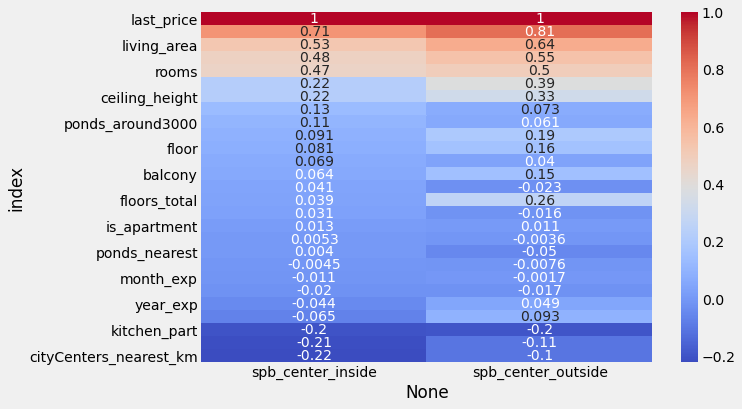

In [48]:
# Для сравнения корреляций двух сигментов сформируем тепловую кату передав ей нужные параметры
sns.heatmap(corr_merged, annot=True, fmt='.2g', cmap= 'coolwarm', cbar=True)
plt.show()

Как видно связь стоимости и общей площади квартиры вне центра увеличивается, что в свою очередь влияет на рост взаимосвязи с другими размерными показателями. Скорее всего такой эффект из-за ослабления влияния центральности квартир. В центральном сигменте, все женьше чем по области, но слегка ярче выглядит обратная связь от удаленности. И даже в ценре люди стремятся к центру. Безразличие к времени публикации объявления сохраняется.

### Шаг 5. Общий вывод
<a class="anchor" id="step_5"></a>

В ходе анализа были удалены, или по возможности заменены пропуски. Отброщены экстремальные значения искажающие средние показатели исследования. Проанализированы взаимосвязи между стоимстью жилья и другими параметрами. Выделены квартиры в центре Санкт-Петербурга и периферии. Вцелом на стоимость жилья наиболее сильное влияние оказывает общая площадь. Такая тенденция прослеживается во всех частях города и области. Отрицательное влияние оказывает удаленность от центра, но вне центрального сигмента все же ослабевает. Время размещения объявления влияет на уровень цены в наименьшей мере. Влияние остальных параметров, наличие прудов, парков, балконов, так же имеет очень не значительное влияние